In [1]:
#=============================================================================================================#
#                                                   IMPORTS                                                   #
#=============================================================================================================


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
from PIL import Image
import cv2
import csv
import copy

from collections import OrderedDict
from scipy import spatial
import glob

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import models
import torchvision.transforms as transforms


import pickle
from joblib import dump, load



import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = '/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/rsna-breast-cancer-256-pngs'

In [3]:
# Image Processing Parameters 
BLUR = 21
CANNY_THRESH_1 = 10
CANNY_THRESH_2 = 20
MASK_DILATE_ITER = 10
MASK_ERODE_ITER = 10
MASK_COLOR = (0.0, 0.0, 1.0) # In BGR format

In [4]:
#Image preprocessing. Create mask and remove backgrounds

def preprocess(filename):
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    

    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cv2.findContours


    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]
    
    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))

    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)

    #-- Create final image ---------------------------------------------------------------
    img[mask <= 100] = 0
    return img
 

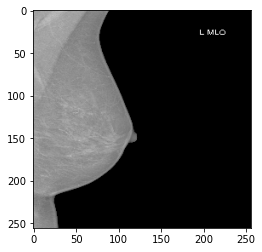

In [5]:
# Preprocessing an example image
filename = 'rsna-breast-cancer/rsna-breast-cancer-256-pngs/5_640805896.png'
img = cv2.imread(filename)
plt.imshow(img);



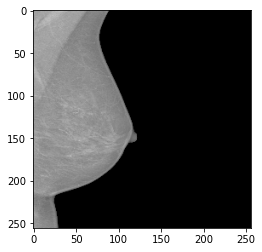

In [6]:

img = preprocess(filename)
plt.imshow(img);

In [7]:
test_files = glob.glob(os.path.join(data_dir, "10006*.png"))
print(test_files)

['/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/rsna-breast-cancer-256-pngs/10006_1459541791.png', '/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/rsna-breast-cancer-256-pngs/10006_1864590858.png', '/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/rsna-breast-cancer-256-pngs/10006_1874946579.png', '/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/rsna-breast-cancer-256-pngs/10006_462822612.png']


In [8]:
df = pd.read_csv('./train.csv')

In [ ]:
#Cancer Left, Cancer Right

In [19]:
print(df)

       site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0            2       10006   462822612          L   CC  61.0       0       0   
1            2       10006  1459541791          L  MLO  61.0       0       0   
2            2       10006  1864590858          R  MLO  61.0       0       0   
3            2       10006  1874946579          R   CC  61.0       0       0   
4            2       10011   220375232          L   CC  55.0       0       0   
...        ...         ...         ...        ...  ...   ...     ...     ...   
54701        1        9973  1729524723          R  MLO  43.0       0       0   
54702        1        9989    63473691          L  MLO  60.0       0       0   
54703        1        9989  1078943060          L   CC  60.0       0       0   
54704        1        9989   398038886          R  MLO  60.0       0       0   
54705        1        9989   439796429          R   CC  60.0       0       0   

       invasive  BIRADS  implant densit

In [9]:
# Test Data: 
# 10006 1459541791 L MLO 61
# 10006 1864590858 R MLO 61

# 10006 462822612 L CC 61
# 10006 1874946579 R CC 61

def get_image_ids(df, patient_id, view):
    image_ids_L = df[(df['patient_id'] == patient_id) & (df['view'] == view) & (df['laterality'] == 'L')]['image_id'].tolist()
    image_ids_R = df[(df['patient_id'] == patient_id) & (df['view'] == view) & (df['laterality'] == 'R')]['image_id'].tolist()
    image_ids = {'L': image_ids_L, 'R': image_ids_R}
    return image_ids


def get_patient_ids(df):
    patient_ids = df['patient_id'].unique().tolist()
    return patient_ids

    

view = 'MLO'
patient_id = 10006
image_ids = get_image_ids(df, patient_id, view)

print("Image ids for MLO view of left laterality: ", image_ids['L'])
print("Image ids for MLO view of right laterality: ", image_ids['R'])

view = 'CC'
image_ids = get_image_ids(df, patient_id, view)

print("Image ids for CC view of left laterality: ", image_ids['L'])
print("Image ids for CC view of right laterality: ", image_ids['R'])

Image ids for MLO view of left laterality:  [1459541791]
Image ids for MLO view of right laterality:  [1864590858]
Image ids for CC view of left laterality:  [462822612]
Image ids for CC view of right laterality:  [1874946579]


In [18]:
# --------Concatenate and preprocess images---------

patient_ids = get_patient_ids(df)
proc_data_dir = '/Users/callamingram/Desktop/RSNA Kaggle Challenge/rsna-breast-cancer/processed'

def concatenate_and_save_images(patient_id, view): 
    image_ids = get_image_ids(df, patient_id, view)

    if(not image_ids['L'] or not image_ids['R']): 
        print("Error: Patient is missing left or right view. Or Patient does not exist.")
        return
    filename_L =  str(patient_id) + "_" + str(image_ids['L'][0]) + '.png'
    filename_R =  str(patient_id) + "_" + str(image_ids['R'][0]) + '.png'
    left_img = preprocess(data_dir + '/' + filename_L)
    right_img = preprocess(data_dir + '/' + filename_R)

    concatenated_img = cv2.hconcat([right_img, left_img])
    concatenated_img = concatenated_img[0:336, 128:384]
    cated_img_name = str(patient_id) + "_" + view

    print(cated_img_name)

    cv2.imwrite(os.path.join(proc_data_dir, cated_img_name + '.png'), concatenated_img)


for patient_id in patient_ids[]: 
    concatenate_and_save_images(patient_id, 'MLO')
    concatenate_and_save_images(patient_id, 'CC')

#Breaks for some reason not super sure why but processes enough data to get started and come back. 
#TODO: Fix this bug so that all views can be processed. 
# ---------------------------------------------------------------------------
# IndexError                                Traceback (most recent call last)
# /Users/callamingram/Desktop/RSNA Kaggle Challenge/RSNA_Radiology_Challenge.ipynb Cell 11 in <cell line: 26>()
#      23     cv2.imwrite(os.path.join(proc_data_dir, cated_img_name + '.png'), concatenated_img)
#      26 for patient_id in patient_ids: 
# ---> 27     concatenate_and_save_images(patient_id, 'MLO')
#      28     concatenate_and_save_images(patient_id, 'CC')

# /Users/callamingram/Desktop/RSNA Kaggle Challenge/RSNA_Radiology_Challenge.ipynb Cell 11 in concatenate_and_save_images(patient_id, view)
#      12 filename_L =  str(patient_id) + "_" + str(image_ids['L'][0]) + '.png'
#      13 filename_R =  str(patient_id) + "_" + str(image_ids['R'][0]) + '.png'
# ---> 14 left_img = preprocess(data_dir + '/' + filename_L)
#      15 right_img = preprocess(data_dir + '/' + filename_R)
#      17 concatenated_img = cv2.hconcat([right_img, left_img])

# /Users/callamingram/Desktop/RSNA Kaggle Challenge/RSNA_Radiology_Challenge.ipynb Cell 11 in preprocess(filename)
#      21     contour_info.append((
#      22         c,
#      23         cv2.isContourConvex(c),
#      24         cv2.contourArea(c),
#      25     ))
#      26 contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
# ---> 27 max_contour = contour_info[0]
#      29 #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
#      30 # Mask is black, polygon is white
#      31 mask = np.zeros(edges.shape)

# IndexError: list index out of range 





10006_MLO
10006_CC


<h3>Creating a custom PyTorch Dataset</h3>

In [ ]:


class BreastCancerDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.nb_views = 2
        self.plug_label_map = self._get_plug_label_map(root + '/train.csv')
        self.plug_names = self._get_plug_names(root)
        self.label_encoder = {'No Cancer': 0, 
                            'Cancer Left': 1, 
                            'Cancer Right': 2} 
        
    def _get_plug_names(self, root):
        plug_names = [fname.split('_')[0] for fname in os.listdir(root) if fname.endswith('.png')]
        plug_names = list(set(plug_names))
        return plug_names
    
    def _get_plug_label_map(self, filename):
        reader = csv.DictReader(open(filename))
        plug_label_map = {}
        for row in reader:
            plug_label_map[row['part_no']] = row['label']
        return plug_label_map
        
    def __len__(self):
        return len(self.plug_names)
    
    def _transform(self, image):
        transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        return transform(image)
    
    def __getitem__(self, index):
        plug_name = self.plug_names[index]
        # Get Images of the Plug
        plug_fnames = glob.glob(self.root + f'/{plug_name}_*.png')
        plug = torch.stack([self._transform(Image.open(fname).convert('RGB')) for fname in plug_fnames])
        label = self.label_encoder[self.plug_label_map[plug_name]]
        return plug, label